In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Get the stock quote
df = yf.download('^GSPC', start = '1970-01-01', end='2021-01-16', progress = False)

In [8]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,92.059998,93.540001,91.790001,93.000000,93.000000,8050000
1970-01-05,93.000000,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,93.459999,93.809998,92.129997,92.820000,92.820000,11460000
1970-01-07,92.820000,93.379997,91.930000,92.629997,92.629997,10010000
1970-01-08,92.629997,93.470001,91.989998,92.680000,92.680000,10670000
...,...,...,...,...,...,...
2021-01-11,3803.139893,3817.860107,3789.020020,3799.610107,3799.610107,4450500000
2021-01-12,3801.620117,3810.780029,3776.510010,3801.189941,3801.189941,4977210000
2021-01-13,3802.229980,3820.959961,3791.500000,3809.840088,3809.840088,4590420000


In [4]:
new_data = df

In [5]:
values = df.values

In [6]:
values

array([[9.20599976e+01, 9.35400009e+01, 9.17900009e+01, 9.30000000e+01,
        9.30000000e+01, 8.05000000e+06],
       [9.30000000e+01, 9.42500000e+01, 9.25299988e+01, 9.34599991e+01,
        9.34599991e+01, 1.14900000e+07],
       [9.34599991e+01, 9.38099976e+01, 9.21299973e+01, 9.28199997e+01,
        9.28199997e+01, 1.14600000e+07],
       ...,
       [3.80222998e+03, 3.82095996e+03, 3.79150000e+03, 3.80984009e+03,
        3.80984009e+03, 4.59042000e+09],
       [3.81497998e+03, 3.82360010e+03, 3.79286011e+03, 3.79554004e+03,
        3.79554004e+03, 5.18014000e+09],
       [3.78872998e+03, 3.78872998e+03, 3.74962012e+03, 3.76825000e+03,
        3.76825000e+03, 5.35306000e+09]])

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

scaled.head()

,0,1,2,3,4,5
0,0.007935,0.008054,0.008261,0.008165,0.008165,0.000122
1,0.008186,0.008242,0.008459,0.008287,0.008287,0.000423
2,0.008309,0.008126,0.008352,0.008117,0.008117,0.000420
3,0.008138,0.008011,0.008299,0.008067,0.008067,0.000293
4,0.008087,0.008035,0.008315,0.008080,0.008080,0.000351


In [10]:
def ts (new_data, look_back = 60, pred_col = 1):
    t = new_data.copy()
    t["id"] = range(1, len(t)+1)
    t = t.iloc[:-look_back, :]
    t.set_index('id', inplace=True)
    pred_value = new_data.copy()
    pred_value = pred_value.iloc[look_back:, pred_col]
    pred_value.columns = ['Pred']
    pred_value = pd.DataFrame(pred_value)
    
    pred_value['id'] = range(1, len(pred_value) + 1)
    pred_value.set_index('id', inplace=True)
    final_df = pd.concat([t, pred_value], axis=1)
    
    return final_df

In [11]:
arr_df = ts(scaled, 60, 0)
arr_df.fillna(0, inplace=True)

arr_df.columns = ['v1(t-60)', 'v2(t-60)', 'v3(t-60)', 'v4(t-60)', 'v5(t-60)', 'v6(t-60)', 'v1(t)']

print(arr_df.head())

    v1(t-60)  v2(t-60)  v3(t-60)  v4(t-60)  v5(t-60)  v6(t-60)     v1(t)
id                                                                      
1   0.007935  0.008054  0.008261  0.008165  0.008165  0.000122  0.007288
2   0.008186  0.008242  0.008459  0.008287  0.008287  0.000423  0.007288
3   0.008309  0.008126  0.008352  0.008117  0.008117  0.000420  0.007405
4   0.008138  0.008011  0.008299  0.008067  0.008067  0.000293  0.007331
5   0.008087  0.008035  0.008315  0.008080  0.008080  0.000351  0.007224


In [12]:
# Split into train and test sets
values = arr_df.values
train_sample = int(len(new_data)*0.8)
train = values[: train_sample, :]
test = values[train_sample:, :]

# Split into input and outputs
xtrain, ytrain = train[:, :-1], train[:, -1]
xtest, ytest = test[:, :-1], test[:, -1]

print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(10300, 6) (10300,) (2516, 6) (2516,)


In [13]:
# Reshaping the data set to 3D with sample size, lookback time steps, and the input features
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(10300, 1, 6) (10300,) (2516, 1, 6) (2516,)


In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (xtrain.shape[1], xtrain.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))

In [17]:
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             11400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 33,551
Trainable params: 33,551
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm = model.fit(xtrain, ytrain, epochs = 15, batch_size = 32, validation_data = (xtest, ytest), shuffle=False)

Epoch 1/15
322/322 [==============================] - 4s 5ms/step - loss: 0.0065 - val_loss: 0.3036
Epoch 2/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0637 - val_loss: 0.3037
Epoch 3/15
322/322 [==============================] - 1s 2ms/step - loss: 0.0750 - val_loss: 0.2995
Epoch 4/15
322/322 [==============================] - 1s 2ms/step - loss: 0.0850 - val_loss: 0.2964
Epoch 5/15
322/322 [==============================] - 1s 2ms/step - loss: 0.0804 - val_loss: 0.2637
Epoch 6/15
322/322 [==============================] - 1s 2ms/step - loss: 0.0926 - val_loss: 0.2589
Epoch 7/15
322/322 [==============================] - 1s 2ms/step - loss: 0.0988 - val_loss: 0.2586
Epoch 8/15
322/322 [==============================] - 1s 2ms/step - loss: 0.1030 - val_loss: 0.2644
Epoch 9/15
322/322 [==============================] - 1s 2ms/step - loss: 0.1051 - val_loss: 0.2750
Epoch 10/15
322/322 [==============================] - 1s 3ms/step - loss: 0.1034 - val_loss: 0.2911

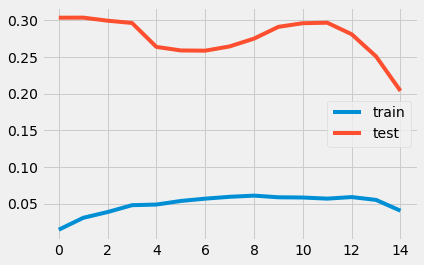

In [32]:
plt.plot(lstm.history['loss'], label='train')
plt.plot(lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
# Make prediction
yhat = model.predict(xtest)
# xtest = xtest.reshape((xtest.shape[0], xtest.shape[2]))

# # inver scaling for forecast
# inv_yhat = concatenate((yhat, xtest[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# # Invert scaling for actual
# ytest = ytest.reshape((len(ytest), 1))
# inv_y = concatenate((ytest, xtest[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# print("Mean absolute error: %f" % sklearn.metrics.mean_absolute_error(inv_y, iny_yhat))

ValueError: in user code:

    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Sam\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:223 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 6)
